In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=d267998d6f73bee4825a5124d7302cd4dc4f389b4a96cb6ac6f1278b31605c8a
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 159.0 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [3]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 491kB 2.8MB/s 
     |████████████████████████████████| 7.1MB 12.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [0]:
from __future__ import print_function
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path
import os

from art.attacks import CarliniL2Method, CarliniLInfMethod, FastGradientMethod
from art.classifiers import PyTorchClassifier
from art.utils import load_cifar10

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
# Read CIFAR10 dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=128)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)
test_dataloader_single = DataLoader(test_dataset, batch_size=1)

In [0]:
file = "PGD_stanford.pth"
pretrained_model = file
use_cuda = True

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
    activations = []             # list to save the activations of the penultimate layer while training on forwardDetect
    mask = torch.zeros(1, 512)   # mask for the forwardMask function for pruning
    

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
    def forwardDetect(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        self.activations.append(x)
        x = self.fc3(x)
        return x
    
    def forwardMask(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))*self.mask
        x = self.fc3(x)
        return x

    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
    
# Initialize the model.
model = Model().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
Model(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.05, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dr

### FGSM

In [12]:
accuracies = []
k = 5000
epsilons = [0.000001, 0.001, .025, .05, .1, .15, .2, .25, .3]

# Run test for each epsilon
for e in epsilons:
    adv_crafter = FastGradientMethod(classifier, eps=e)
    x_test_adv = adv_crafter.generate(x=x_test[:k])
    predictions = classifier.predict(x_test_adv)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:k], axis=1)) / k
    accuracies.append(accuracy)
    print("Epsilon: {}   Test Accuracy = {}".format(e, accuracy))
    
print(accuracies)

Epsilon: 1e-06   Test Accuracy = 0.672
Epsilon: 0.001   Test Accuracy = 0.671
Epsilon: 0.025   Test Accuracy = 0.548
Epsilon: 0.05   Test Accuracy = 0.413
Epsilon: 0.1   Test Accuracy = 0.2516
Epsilon: 0.15   Test Accuracy = 0.1798
Epsilon: 0.2   Test Accuracy = 0.1492
Epsilon: 0.25   Test Accuracy = 0.1354
Epsilon: 0.3   Test Accuracy = 0.1298
[0.672, 0.671, 0.548, 0.413, 0.2516, 0.1798, 0.1492, 0.1354, 0.1298]


### Carlini

In [0]:
# Generate adversarial test examples
def CarliniL2(classifier, x_test, init_const):
    attack = CarliniL2Method(classifier=classifier,
                            confidence=0.0,
                            targeted=False,
                            learning_rate=0.01,
                            binary_search_steps=2,
                            initial_const=init_const,
                            batch_size=64)
    x_test_adv = attack.generate(x=x_test)    
    return x_test_adv

def CarliniLInf(classifier, x_test, epsilon):
    attack = CarliniLInfMethod(classifier=classifier, 
                              confidence=0.0,
                              targeted=False, 
                              learning_rate=0.01,
                              eps=epsilon, 
                              batch_size=128)
    x_test_adv = attack.generate(x=x_test)
    return x_test_adv

# Calculate distance 
def L2distance(x_test, x_test_adv):
    dist = 0
    samples_changed = 0
    for test, adv_test in zip(x_test, x_test_adv):
        l2 = np.linalg.norm(test-adv_test)
        dist += l2
        samples_changed = samples_changed + 1 if l2>0 else samples_changed
    dist /= samples_changed
    return dist

In [9]:
constants = [0.001, 0.01, 0.025, 0.05, 0.1]
constants = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2.5]
n = 1000
accuracies = []
distances = []
for init in constants:
    x_test_adv = CarliniL2(classifier, x_test[:n], init_const=init)
    predictions = classifier.predict(x_test_adv)
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(round(acc, 3))
    dist = L2distance(x_test[:n], x_test_adv)
    distances.append(round(dist, 3))

    print('c:', init, ' Accuracy:', acc, ' Distance:', round(distances[-1], 3))

c: 0.001  Accuracy: 0.648  Distance: 0.022
c: 0.01  Accuracy: 0.312  Distance: 0.082
c: 0.025  Accuracy: 0.201  Distance: 0.115
c: 0.05  Accuracy: 0.162  Distance: 0.14
c: 0.1  Accuracy: 0.149  Distance: 0.169
c: 0.2  Accuracy: 0.141  Distance: 0.21
c: 0.3  Accuracy: 0.141  Distance: 0.238
c: 0.4  Accuracy: 0.14  Distance: 0.265
c: 0.5  Accuracy: 0.141  Distance: 0.279
c: 0.75  Accuracy: 0.138  Distance: 0.32
c: 1  Accuracy: 0.14  Distance: 0.352
c: 2.5  Accuracy: 0.138  Distance: 0.493


In [10]:
print(accuracies, distances)

[0.648, 0.312, 0.201, 0.162, 0.149, 0.141, 0.141, 0.14, 0.141, 0.138, 0.14, 0.138] [0.022, 0.082, 0.115, 0.14, 0.169, 0.21, 0.238, 0.265, 0.279, 0.32, 0.352, 0.493]


In [11]:
epsilons = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]
epsilons = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.010, 0.015, 0.03, 0.06, 0.1]
n = 1000
accuracies = []
for eps in epsilons:
    x_test_adv = CarliniLInf(classifier, x_test[:n], epsilon=eps)
    predictions = classifier.predict(x_test_adv)
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(round(acc, 3))

    print('eps:', eps, ' Accuracy:', acc)

print(accuracies)

eps: 0.001  Accuracy: 0.678
eps: 0.002  Accuracy: 0.605
eps: 0.003  Accuracy: 0.56
eps: 0.004  Accuracy: 0.493
eps: 0.005  Accuracy: 0.419
eps: 0.006  Accuracy: 0.357
eps: 0.01  Accuracy: 0.239
eps: 0.015  Accuracy: 0.178
eps: 0.03  Accuracy: 0.151
eps: 0.06  Accuracy: 0.144
eps: 0.1  Accuracy: 0.146
[0.678, 0.605, 0.56, 0.493, 0.419, 0.357, 0.239, 0.178, 0.151, 0.144, 0.146]


# Results

### FGSM

In [0]:
epsilons = [0.000001, 0.001, .025, .05, .1, .15, .2, .25, .3]
data_2 = {
    'Baseline model': [0.786, 0.7584, 0.215, 0.163, 0.145, 0.139, 0.132, 0.132, 0.132],
    'FGSM adversarial model': [0.7162, 0.688, 0.6252, 0.7074, 0.7152, 0.7018, 0.686, 0.647, 0.6048],
    'PGD adversarial model': [0.672, 0.671, 0.548, 0.413, 0.2516, 0.1798, 0.1492, 0.1354, 0.1298]
}

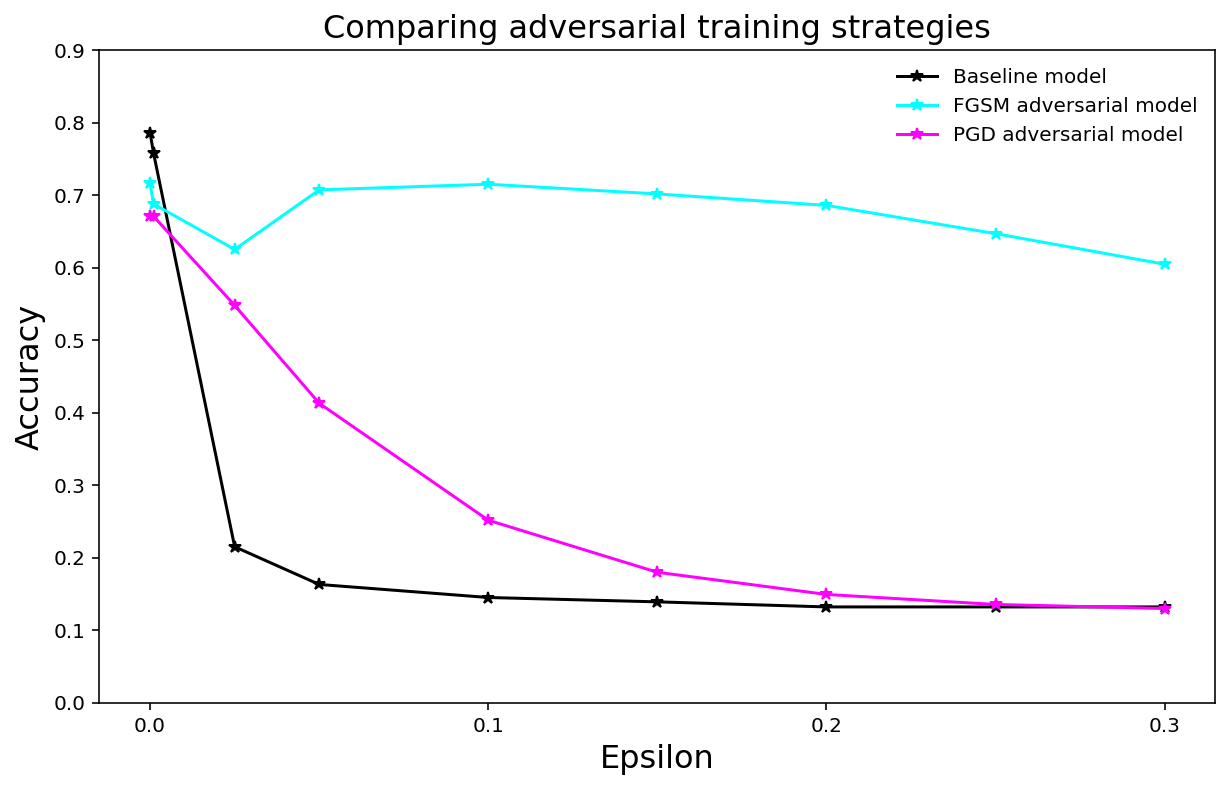

In [14]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))
colors =  ['black', 'cyan', 'fuchsia']

for idx, (l, results) in enumerate(data_2.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=l)

plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 0.31, step=0.1))
plt.title("Comparing adversarial training strategies",fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

### Carlini

In [0]:
# L2
constants = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2.5]
data = {
        'Baseline model': [0.732, 0.313, 0.16, 0.127, 0.116, 0.113, 0.113, 0.113, 0.113, 0.113, 0.113, 0.113],
        'FGSM adversarial model': [0.648, 0.312, 0.201, 0.162, 0.149, 0.141, 0.141, 0.14, 0.141, 0.138, 0.14, 0.138],
        'PGD adversarial model': [0.677, 0.675, 0.674, 0.669, 0.662, 0.619, 0.597 , 0.557, 0.525, 0.439, 0.367, 0.198]
}

In [0]:
# Linf
epsilons = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.010, 0.015, 0.03, 0.06, 0.1]
data_3 = {
        'Baseline model': [0.757, 0.694, 0.609, 0.531, 0.471, 0.407, 0.234, 0.139, 0.113, 0.113, 0.113],
        'FGSM adversarial model': [0.678, 0.605, 0.56, 0.493, 0.419, 0.357, 0.239, 0.178, 0.151, 0.144, 0.146],
        'PGD adversarial model': [0.676, 0.677, 0.667, 0.667, 0.651, 0.647, 0.626, 0.586, 0.465, 0.268, 0.183]
}

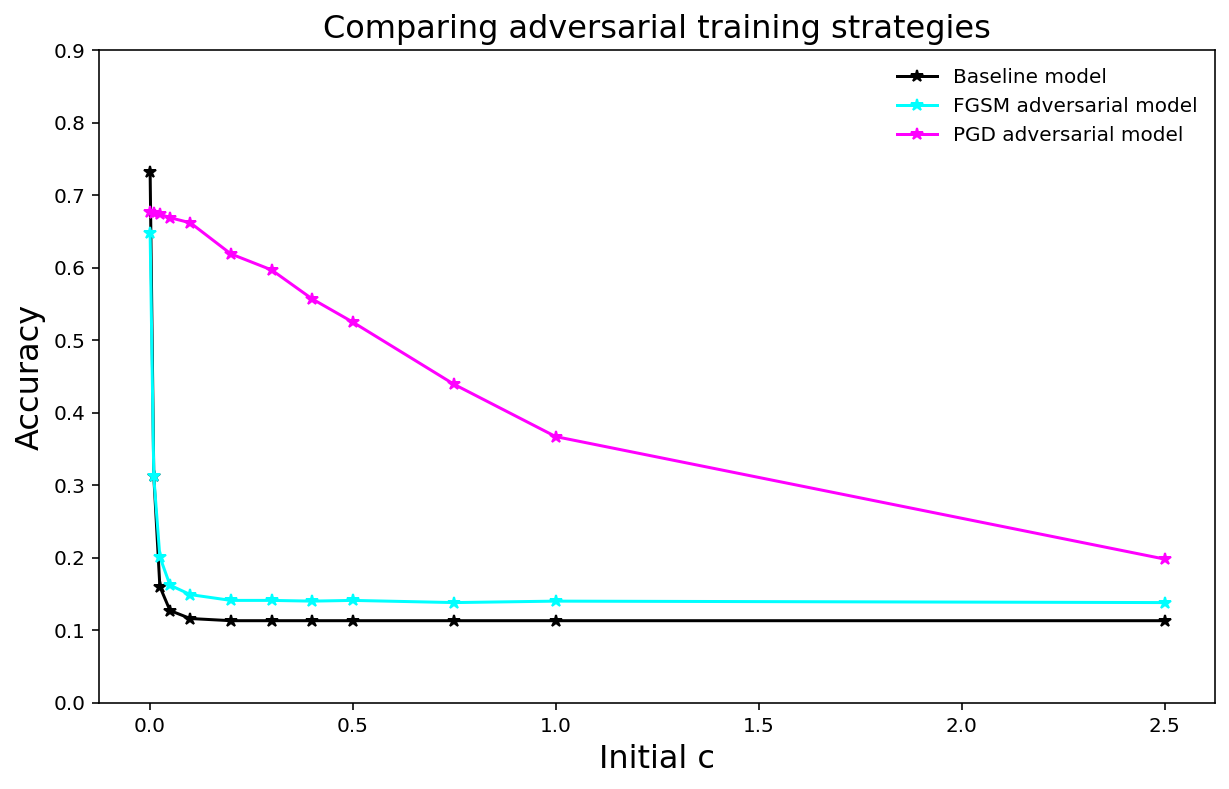

In [9]:
# plot the pruned accuracies vs constant c

plt.figure(figsize=(10,6))
colors =  ['black', 'cyan', 'fuchsia']

for idx, (l, results) in enumerate(data.items()):
    plt.plot(constants, results, "*-", color=colors[idx], label=l)

plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 3, step=0.5))
plt.title("Comparing adversarial training strategies",fontsize=16)
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

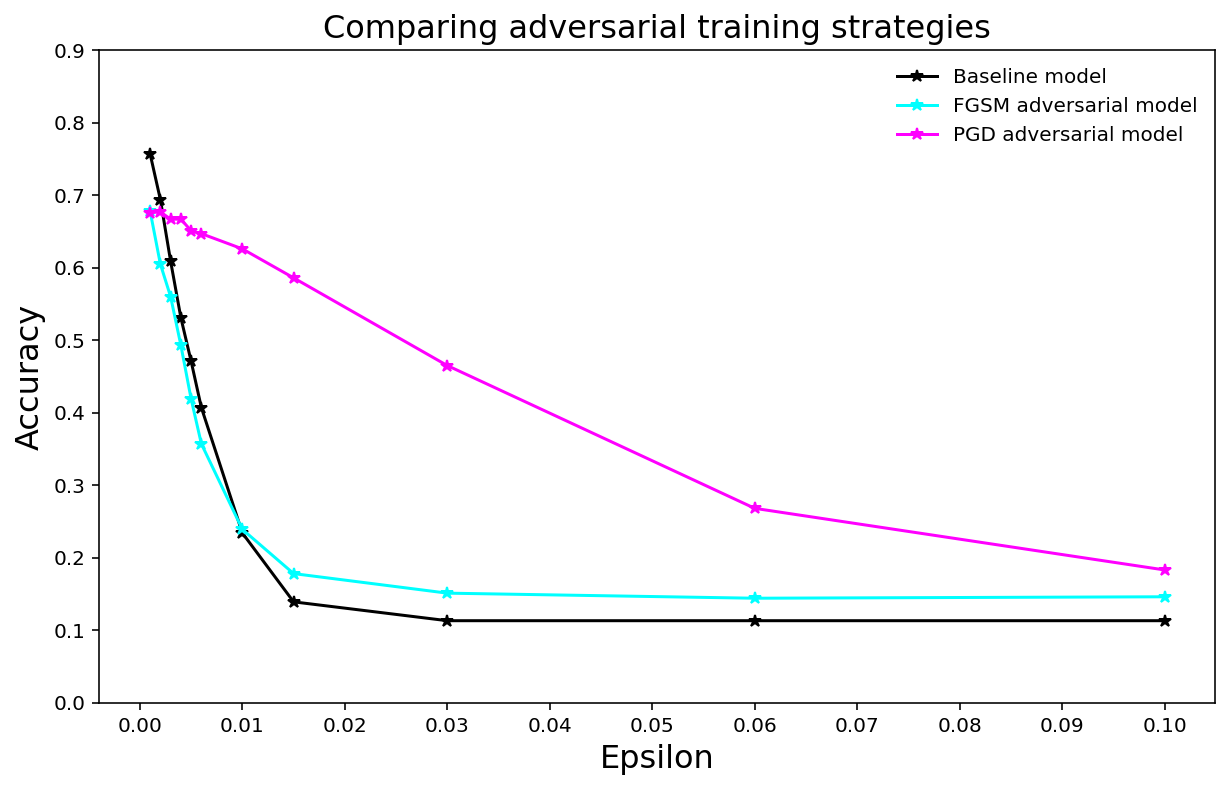

In [10]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))
colors =  ['black', 'cyan', 'fuchsia']

for idx, (l, results) in enumerate(data_3.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=l)

plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 0.11, step=0.01))
plt.title("Comparing adversarial training strategies",fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

In [0]:
# Distance
data_2 = {
        '0': [0.028, 0.125, 0.178, 0.204, 0.233, 0.276, 0.309, 0.33, 0.345, 0.384, 0.404, 0.497],
        'FGSM adversarial model': [0.022, 0.082, 0.115, 0.14, 0.169, 0.21, 0.238, 0.265, 0.279, 0.32, 0.352, 0.493],
        'PGD': [0.001, 0.009, 0.024, 0.047, 0.091, 0.157, 0.218, 0.276 , 0.32]
}